In [50]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

In [51]:
# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

all VISp experiment containers: 216


In [52]:
import pandas as pd

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
print("direction-selective cells: %d" % len(dsi_cells))


total cells: 63251
VISp cells: 22641
cells with sig. response to drifting gratings: 13401
direction-selective cells: 1159


In [53]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
dsi_ec_ids = dsi_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(dsi_ec_ids))

# Download the ophys experiments containing the drifting gratings stimulus for VISp experiment containers
dsi_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_ec_ids, stimuli=[stim_info.DRIFTING_GRATINGS])
print("VISp drifting gratings ophys experiments: %d" % len(dsi_exps))

total dsi experiment containers: 104
VISp drifting gratings ophys experiments: 104


In [54]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np

def plot_stimulus_table(stim_table, title):
    fstart = stim_table.start.min()
    fend = stim_table.end.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    for i, trial in stim_table.iterrows():    
        x1 = float(trial.start - fstart) / (fend - fstart)
        x2 = float(trial.end - fstart) / (fend - fstart)            
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
    ax.set_xticks((0,1))
    ax.set_xticklabels((fstart, fend))
    ax.set_yticks(())
    ax.set_title(title)
    ax.set_xlabel("frames")


In [81]:

# index: index of direction selective cell
def my_func(index, freq, ori):
    
    # pick a direction-selective cell and find its NWB file
    dsi_cell = dsi_cells.iloc[index]
    
    # figure out which ophys experiment has the drifting gratings stimulus for that cell
    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[dsi_cell['cell_specimen_id']],
                                         stimuli=[stim_info.DRIFTING_GRATINGS])[0]

    data_set = boc.get_ophys_experiment_data(cell_exp['id'])
    
    print("Metadata from NWB file:")
    pprint.pprint(data_set.get_metadata())
    
    dsi_cell_id = dsi_cell['cell_specimen_id']
    time, dff_traces = data_set.get_dff_traces(cell_specimen_ids=[dsi_cell_id])
    
    # this is a pandas DataFrame. find trials with a given stimulus condition.
    # 40 diff total conditions
    temporal_frequency = freq
    orientation = ori
    stim_table = data_set.get_stimulus_table('drifting_gratings')
    stim_table = stim_table[(stim_table.temporal_frequency == temporal_frequency) & 
                            (stim_table.orientation == orientation)]
    
    # plot of instances of stimulus frames
    plot_stimulus_table(stim_table, "Instances of Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
    plt.show()
    
    list_of_f = [ [0]*120 for i in range(15)] # 120 data points for each of the 15 trials
    x=0
    # plot 15 fluorescence graphs
    for start_ind in stim_table.start:
        plt.plot(time[:len(dff_traces[0])][start_ind-30:start_ind+90]-time[start_ind-30], 
                 dff_traces[0][start_ind-30:start_ind+90],color='tan')
        plt.title("Fluorescence from frames %d to %d" % (start_ind-30,start_ind+90))
        plt.xlabel("seconds")
        plt.ylabel("dF/F")
        
        # Shade the area of the stimulus
        plt.fill_between(time[:len(dff_traces[0])][start_ind+30:start_ind+90]-time[start_ind], 
                         0.2, -0.2,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.4)          # Transparency of the fill
        
        plt.show()
        list_of_f[x] = dff_traces[0][start_ind-30:start_ind+90]
        x+=1
    
    mean_dff = np.mean((list_of_f[0],list_of_f[1],list_of_f[2],list_of_f[3],list_of_f[4],list_of_f[5],list_of_f[6]
                 ,list_of_f[7],list_of_f[8],list_of_f[9],list_of_f[10],list_of_f[11],list_of_f[12],list_of_f[13],
                 list_of_f[14]), axis=0)
    
    plt.plot(time[:len(dff_traces[0])][0:120]-time[0],mean_dff, color='black')
    plt.title("Average Fluroescence for Stimulus: TF %d ORI %d" % (temporal_frequency, orientation))
    plt.xlabel("seconds")
    plt.ylabel("dF/F")
    plt.fill_between(time[:len(dff_traces[0])][start_ind+30:start_ind+90]-time[start_ind], 0.05, -0.05,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.4)          # Transparency of the fill
    plt.show()
    
    
    

Metadata from NWB file:
{'age_days': 93,
 'cre_line': 'Scnn1a-Tg3-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 511498742,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'imaging_depth_um': 350,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 511534603,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 4, 1, 9, 12, 3),
 'session_type': 'three_session_A',
 'sex': 'female',
 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-231953',
 'targeted_structure': 'VISp'}


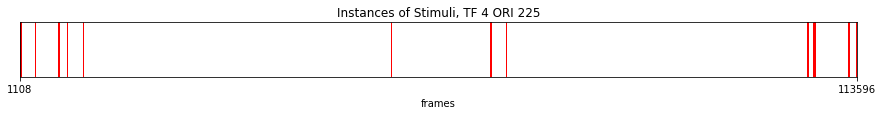

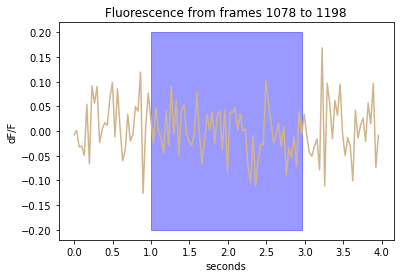

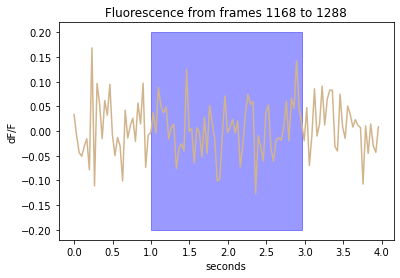

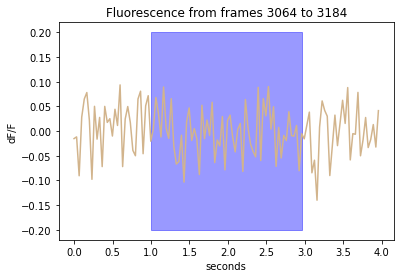

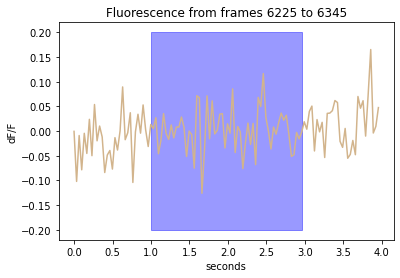

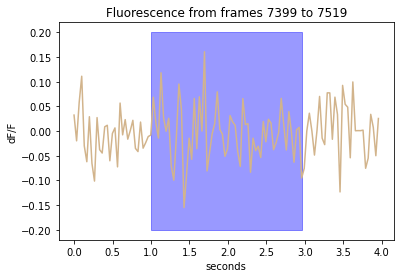

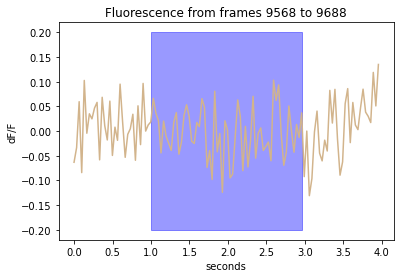

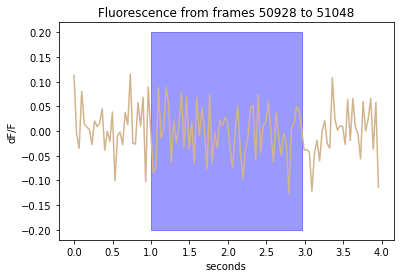

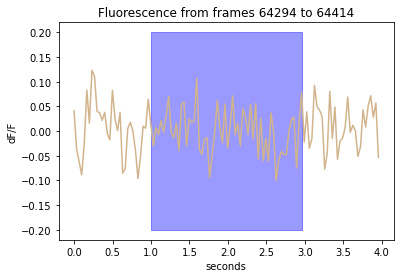

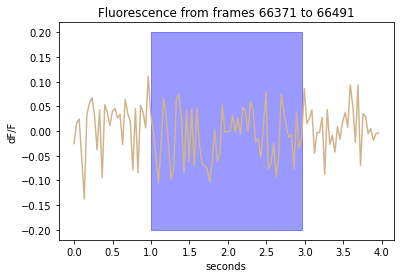

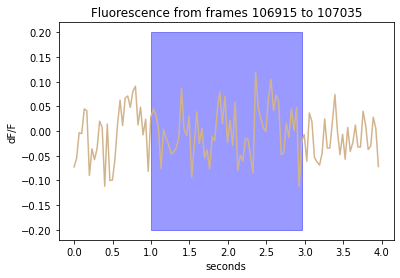

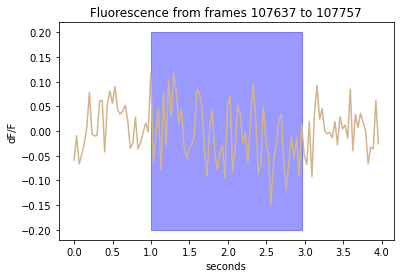

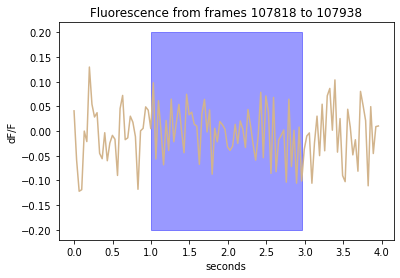

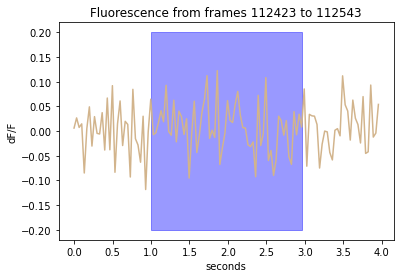

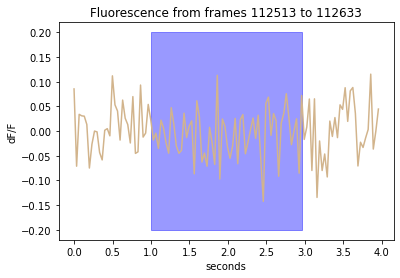

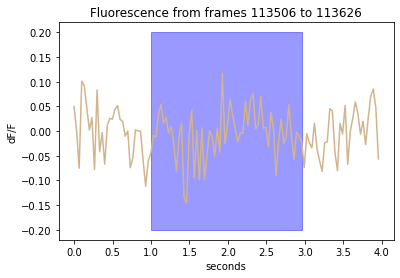

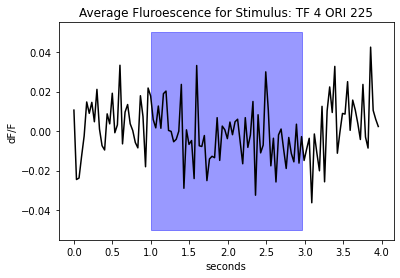

In [82]:
my_func(0, 4, 225)

Metadata from NWB file:
{'age_days': 93,
 'cre_line': 'Scnn1a-Tg3-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 511498742,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'imaging_depth_um': 350,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 511534603,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 4, 1, 9, 12, 3),
 'session_type': 'three_session_A',
 'sex': 'female',
 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-231953',
 'targeted_structure': 'VISp'}


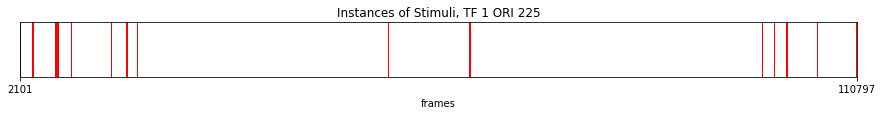

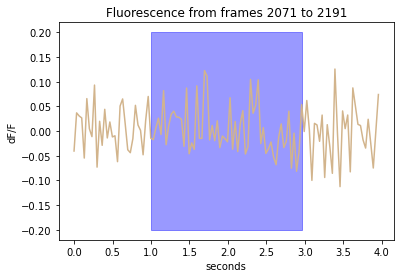

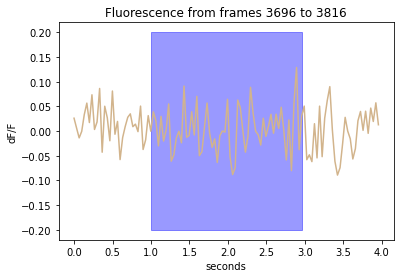

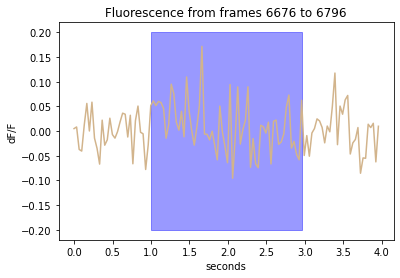

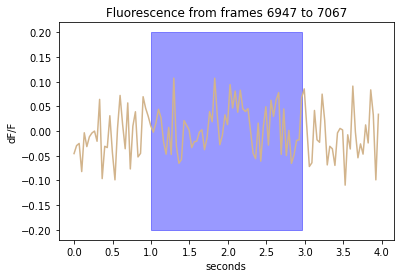

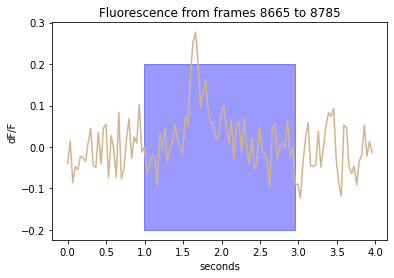

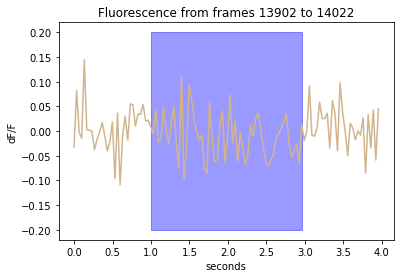

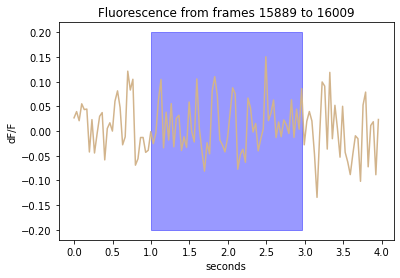

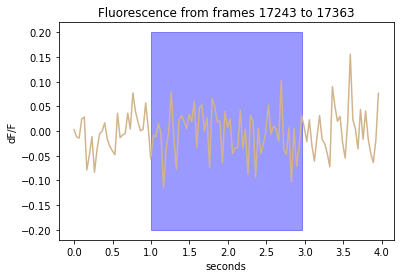

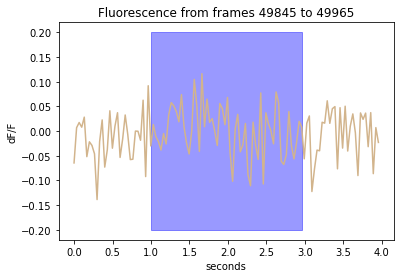

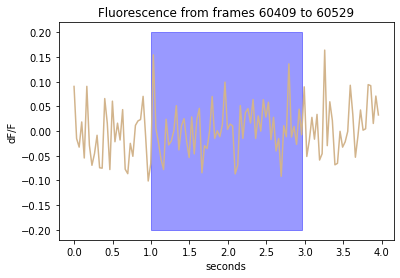

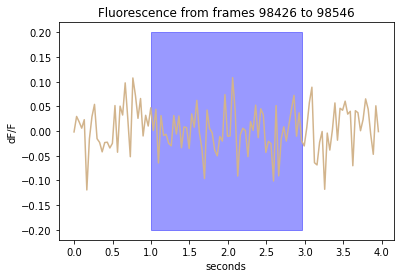

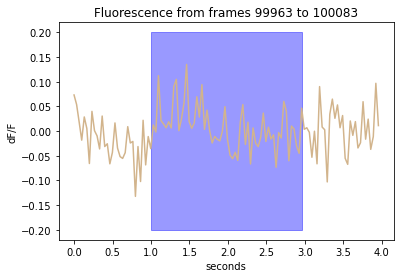

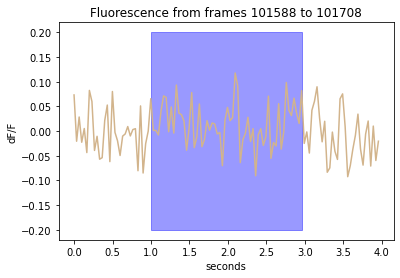

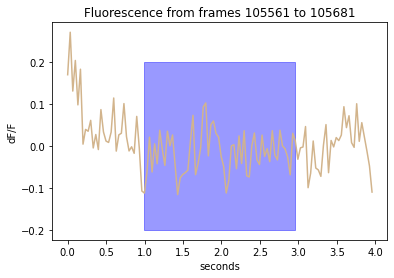

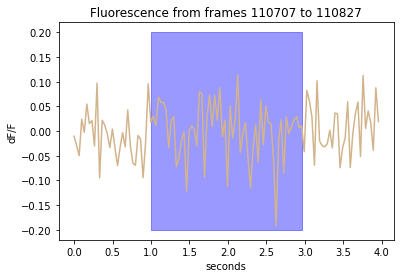

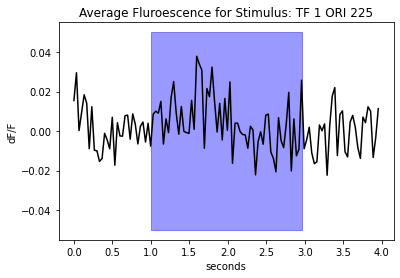

In [84]:
my_func(0, 1, 225)


In [ ]:
#running speed